In [1]:
"""
Application of ConvNext, Swin Transformer, and VGG19 for AI Generated Image Detection

Author: James Michael Fritz 

Date Created: 25/03/2023
Date Revised: 11/07/2023

This notebook demonstrates the implementation of the ConvNext, Swin Transformer,
and VGG19 to detect AI Generated Images
"""

'\nDeep Ensemble Neural Network (DENN) for AI Generated Image Detection\n\nAuthor: James Michael Fritz \n\nDate Created: 25/03/2023\nDate Revised: 11/07/2023\n\nThis notebook demonstrates the implementation of the DENN model,\nwhich is a deep ensemble neural network that combines the outputs of\nVGG19 and ConvNeXt models.\n'

In [2]:
# Imports here
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision import models
from collections import OrderedDict
import seaborn as sns
import json
from sklearn.metrics import classification_report

In [3]:
# hyperparameters
BATCH_SIZE = 512
EPOCHS = 5
LR = 5e-4
LR_DECAY = 0.7
WEIGHT_DECAY = 1e-2

In [4]:
train_dir = 'train'
test_dir = 'test'

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the dataset using ImageFolder
image_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Split the dataset into train and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size

train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
from torch.nn import DataParallel

def fit_model(model, epochs, train_dataloader, val_dataloader, criterion, optimizer, scheduler):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model = DataParallel(model)
    
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")

        model.train()
        train_loss = []
        train_acc = []
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_loss.append(loss.item()) 
            optimizer.step()

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc.append(acc.item()) 

            if i % 100 == 0 and i != 0:
                print(f"Batch: {i:03d}/{len(train_dataloader)}", end= " | ")
                print(f"Train loss: {loss.item():.4f}", end=" | ")
                print(f"Train accuracy: {acc.item():.4f}", end=" | ")
                print()

        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        
        epoch_train_loss.append(avg_train_loss)
        epoch_train_acc.append(avg_train_acc)

        print(f"Train loss: \t\t{avg_train_loss:.4f}", end=" | ")
        print(f"Train accuracy: \t{avg_train_acc:.4f}", end=" | ")
        print()

        scheduler.step() # update lr on every batch

        model.eval()
        val_loss = []
        val_acc = []
        for i, (inputs, labels) in enumerate(val_dataloader):
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item()) 

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                val_acc.append(acc.item()) 

        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
    
        epoch_val_loss.append(avg_val_loss)
        epoch_val_acc.append(avg_val_acc)
        
        print(f"Validation loss: \t{avg_val_loss:.4f}", end=" | ")
        print(f"Validation accuracy: \t{avg_val_acc:.4f}", end=" | ")
        print()
        
    history = {
        'train_loss': epoch_train_loss,
        'train_acc' : epoch_train_acc,
        'val_loss' : epoch_val_loss,
        'val_acc' : epoch_val_acc
    }
    
    return history

In [7]:
# Using vgg19 as base model
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

# we don't want to disrupt the learned weights of the pretrained model, so we set 'requires_grad' to False
for param in vgg19.parameters():
    param.requires_grad = False
    
vgg19_classifier = nn.Sequential(OrderedDict([
    ('inputs', nn.Linear(25088, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('hidden_layer1', nn.Linear(512, 128)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('hidden_layer2', nn.Linear(128, 128)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('hidden_layer3', nn.Linear(128, 2)),
    ('output', nn.LogSoftmax(dim=1)),
]))

vgg19.classifier = vgg19_classifier

optimizer_vgg19 = optim.AdamW(vgg19.classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler_vgg19 = lr_scheduler.ExponentialLR(optimizer_vgg19, gamma=LR_DECAY, last_epoch=-1)

In [8]:
# Using convnext as base model
convnext = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)

for param in convnext.parameters():
    param.requires_grad = False
    
convnext_classifier = nn.Sequential(OrderedDict([
    ('flatten', nn.Flatten()),
    ('inputs', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('hidden_layer1', nn.Linear(512, 128)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('hidden_layer2', nn.Linear(128, 128)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('hidden_layer3', nn.Linear(128, 2)),
    ('output', nn.LogSoftmax(dim=1)),
]))

convnext.classifier = convnext_classifier

optimizer_convnext = optim.AdamW(convnext.classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler_convnext = lr_scheduler.ExponentialLR(optimizer_convnext, gamma=LR_DECAY, last_epoch=-1)

In [22]:
# Using swin as base model
swin = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)

for param in swin.parameters():
    param.requires_grad = False
    
swin_classifier = nn.Sequential(OrderedDict([
    ('flatten', nn.Flatten()),
    ('inputs', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('hidden_layer1', nn.Linear(512, 128)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('hidden_layer2', nn.Linear(128, 128)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('hidden_layer3', nn.Linear(128, 2)),
    ('output', nn.LogSoftmax(dim=1)),
]))

swin.head = swin_classifier

optimizer_swin = optim.AdamW(swin.head.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler_swin = lr_scheduler.ExponentialLR(optimizer_swin, gamma=LR_DECAY, last_epoch=-1)

In [24]:
def eval_model(model, test_dataloader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model = DataParallel(model)
    model.eval()
    
    test_loss = []
    test_acc = []
    y_true = []
    y_pred = []

    for i, (inputs, labels) in enumerate(test_dataloader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_true.extend(labels.cpu().numpy())

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item()) 

            _, predictions = torch.max(outputs.data, 1)
            y_pred.extend(predictions.cpu().numpy())
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc.append(acc.item()) 

    avg_test_loss = sum(test_loss) / len(test_loss)
    avg_test_acc = sum(test_acc) / len(test_acc)

    print("Evaluation Results\n")
    print(f"Test loss: {avg_test_loss:.4f}", end=" | ")
    print(f"Test accuracy: {avg_test_acc:.4f}", end=" | ")
    print("\n")

    # Create a list of class names in the same order as their integer labels
    class_to_idx = image_dataset.class_to_idx
    classes = [k for k, v in class_to_idx.items()]

    # Convert integer labels to their corresponding class names
    y_true = [classes[label] for label in y_true]
    y_pred = [classes[label] for label in y_pred]

    # Print the classification report with categorical labels
    print(classification_report(y_true, y_pred, digits=4))

In [11]:
criterion = nn.NLLLoss()

In [12]:
vgg19_history = fit_model(
    model=vgg19,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer_vgg19,
    scheduler=scheduler_vgg19,
)

Epoch: 1/5
Learning rate: 0.0005
Batch: 100/157 | Train loss: 0.2452 | Train accuracy: 0.9004 | 
Train loss: 		0.2546 | Train accuracy: 	0.8932 | 
Validation loss: 	0.1872 | Validation accuracy: 	0.9258 | 
Epoch: 2/5
Learning rate: 0.00035
Batch: 100/157 | Train loss: 0.1139 | Train accuracy: 0.9512 | 
Train loss: 		0.1237 | Train accuracy: 	0.9531 | 
Validation loss: 	0.1648 | Validation accuracy: 	0.9384 | 
Epoch: 3/5
Learning rate: 0.000245
Batch: 100/157 | Train loss: 0.0548 | Train accuracy: 0.9805 | 
Train loss: 		0.0595 | Train accuracy: 	0.9784 | 
Validation loss: 	0.1703 | Validation accuracy: 	0.9450 | 
Epoch: 4/5
Learning rate: 0.0001715
Batch: 100/157 | Train loss: 0.0152 | Train accuracy: 0.9941 | 
Train loss: 		0.0236 | Train accuracy: 	0.9920 | 
Validation loss: 	0.2133 | Validation accuracy: 	0.9454 | 
Epoch: 5/5
Learning rate: 0.00012004999999999999
Batch: 100/157 | Train loss: 0.0202 | Train accuracy: 0.9941 | 
Train loss: 		0.0096 | Train accuracy: 	0.9972 | 
Validat

In [13]:
convnext_history = fit_model(
    model=convnext,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer_convnext,
    scheduler=scheduler_convnext,
)

Epoch: 1/5
Learning rate: 0.0005
Batch: 100/157 | Train loss: 0.2355 | Train accuracy: 0.9043 | 
Train loss: 		0.2852 | Train accuracy: 	0.8808 | 
Validation loss: 	0.1561 | Validation accuracy: 	0.9400 | 
Epoch: 2/5
Learning rate: 0.00035
Batch: 100/157 | Train loss: 0.1561 | Train accuracy: 0.9375 | 
Train loss: 		0.1672 | Train accuracy: 	0.9351 | 
Validation loss: 	0.1249 | Validation accuracy: 	0.9533 | 
Epoch: 3/5
Learning rate: 0.000245
Batch: 100/157 | Train loss: 0.1114 | Train accuracy: 0.9629 | 
Train loss: 		0.1409 | Train accuracy: 	0.9454 | 
Validation loss: 	0.1147 | Validation accuracy: 	0.9579 | 
Epoch: 4/5
Learning rate: 0.0001715
Batch: 100/157 | Train loss: 0.1350 | Train accuracy: 0.9453 | 
Train loss: 		0.1260 | Train accuracy: 	0.9528 | 
Validation loss: 	0.1013 | Validation accuracy: 	0.9626 | 
Epoch: 5/5
Learning rate: 0.00012004999999999999
Batch: 100/157 | Train loss: 0.1596 | Train accuracy: 0.9473 | 
Train loss: 		0.1167 | Train accuracy: 	0.9557 | 
Validat

In [23]:
swin_history = fit_model(
    model=swin,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer_swin,
    scheduler=scheduler_swin,
)

Epoch: 1/5
Learning rate: 0.0005
Batch: 100/157 | Train loss: 0.2306 | Train accuracy: 0.9141 | 
Train loss: 		0.2881 | Train accuracy: 	0.8763 | 
Validation loss: 	0.1586 | Validation accuracy: 	0.9396 | 
Epoch: 2/5
Learning rate: 0.00035
Batch: 100/157 | Train loss: 0.1643 | Train accuracy: 0.9375 | 
Train loss: 		0.1810 | Train accuracy: 	0.9281 | 
Validation loss: 	0.1377 | Validation accuracy: 	0.9471 | 
Epoch: 3/5
Learning rate: 0.000245
Batch: 100/157 | Train loss: 0.1577 | Train accuracy: 0.9414 | 
Train loss: 		0.1565 | Train accuracy: 	0.9393 | 
Validation loss: 	0.1229 | Validation accuracy: 	0.9535 | 
Epoch: 4/5
Learning rate: 0.0001715
Batch: 100/157 | Train loss: 0.1337 | Train accuracy: 0.9453 | 
Train loss: 		0.1409 | Train accuracy: 	0.9455 | 
Validation loss: 	0.1206 | Validation accuracy: 	0.9562 | 
Epoch: 5/5
Learning rate: 0.00012004999999999999
Batch: 100/157 | Train loss: 0.1076 | Train accuracy: 0.9609 | 
Train loss: 		0.1327 | Train accuracy: 	0.9489 | 
Validat

In [25]:
eval_model(
    model=vgg19,
    test_dataloader=test_dataloader
)

Evaluation Results

Test loss: 0.2539 | Test accuracy: 0.9425 | 

              precision    recall  f1-score   support

        FAKE     0.9347    0.9518    0.9432     10000
        REAL     0.9509    0.9335    0.9421     10000

    accuracy                         0.9426     20000
   macro avg     0.9428    0.9426    0.9426     20000
weighted avg     0.9428    0.9426    0.9426     20000



In [26]:
eval_model(
    model=convnext,
    test_dataloader=test_dataloader
)

Evaluation Results

Test loss: 0.1163 | Test accuracy: 0.9554 | 

              precision    recall  f1-score   support

        FAKE     0.9313    0.9842    0.9570     10000
        REAL     0.9832    0.9274    0.9545     10000

    accuracy                         0.9558     20000
   macro avg     0.9573    0.9558    0.9558     20000
weighted avg     0.9573    0.9558    0.9558     20000



In [27]:
eval_model(
    model=swin,
    test_dataloader=test_dataloader
)

Evaluation Results

Test loss: 0.1091 | Test accuracy: 0.9585 | 

              precision    recall  f1-score   support

        FAKE     0.9475    0.9718    0.9595     10000
        REAL     0.9711    0.9462    0.9585     10000

    accuracy                         0.9590     20000
   macro avg     0.9593    0.9590    0.9590     20000
weighted avg     0.9593    0.9590    0.9590     20000



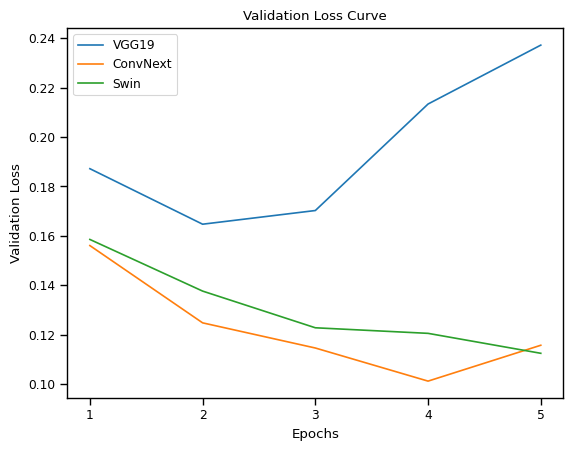

In [48]:
sns.set_context('paper')

sns.lineplot(x=range(1, 6), y=vgg19_history['val_loss'], label='VGG19')
sns.lineplot(x=range(1, 6), y=convnext_history['val_loss'], label='ConvNext')
sns.lineplot(x=range(1, 6), y=swin_history['val_loss'], label='Swin')

plt.xticks(range(1, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curve')

plt.legend()

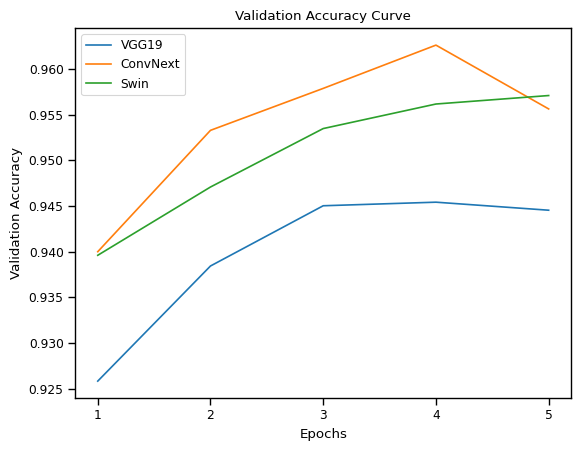

In [50]:
sns.lineplot(x=range(1, 6), y=vgg19_history['val_acc'], label='VGG19')
sns.lineplot(x=range(1, 6), y=convnext_history['val_acc'], label='ConvNext')
sns.lineplot(x=range(1, 6), y=swin_history['val_acc'], label='Swin')

plt.xticks(range(1, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curve')

plt.legend()

In [28]:
torch.save(vgg19, "VGG19-CIFAKE.pth")
torch.save(convnext, "ConvNext-CIFAKE.pth")
torch.save(swin, "Swin-CIFAKE.pth")